In [1]:
from tqdm import tqdm 
import torch
import torch.nn.functional as F
from torch import nn
from torch.utils.data import DataLoader
from utils.base import eval_accuracy
from utils.base import get_correct_predictions_subset
from utils.data import create_butterfly_dataset
from model.butterfly_classifier import DenseNet121
from algo.attacker import adversarial_generator
from torch.utils.data import DataLoader
import torch.nn.functional as F

# (0) Download Butterfly 

In [1]:
!kaggle datasets download -d gpiosenka/butterfly-images40-species


  0%|          | 0.00/399M [00:00<?, ?B/s]
  0%|          | 1.00M/399M [00:00<02:22, 2.92MB/s]
  1%|          | 2.00M/399M [00:00<01:36, 4.31MB/s]
  1%|          | 3.00M/399M [00:00<01:12, 5.72MB/s]
  1%|          | 4.00M/399M [00:00<01:08, 6.09MB/s]
  2%|▏         | 8.00M/399M [00:00<00:30, 13.4MB/s]
  3%|▎         | 10.0M/399M [00:01<00:26, 15.3MB/s]
  3%|▎         | 12.0M/399M [00:01<00:34, 11.8MB/s]
  4%|▍         | 17.0M/399M [00:01<00:20, 19.8MB/s]
  5%|▌         | 20.0M/399M [00:01<00:20, 19.2MB/s]
  6%|▌         | 24.0M/399M [00:01<00:18, 20.9MB/s]
  7%|▋         | 28.0M/399M [00:01<00:18, 21.3MB/s]
  8%|▊         | 31.0M/399M [00:02<00:27, 13.9MB/s]
  8%|▊         | 33.0M/399M [00:02<00:27, 13.9MB/s]
  9%|▉         | 35.0M/399M [00:02<00:31, 12.2MB/s]
 10%|▉         | 39.0M/399M [00:02<00:22, 16.8MB/s]
 11%|█         | 43.0M/399M [00:02<00:17, 21.0MB/s]
 12%|█▏        | 48.0M/399M [00:03<00:13, 26.7MB/s]
 13%|█▎        | 52.0M/399M [00:03<00:24, 14.6MB/s]
 14%|█▍        | 55.

In [2]:
import zipfile
with zipfile.ZipFile('butterfly-images40-species.zip', 'r') as zip_ref:
    zip_ref.extractall('data/butterfly')

# (1) Process Butterfly Data

In [2]:
trainset, testset, normal_mapping, reverse_mapping, image_dict = create_butterfly_dataset()
assert len(trainset) == 12594, 'Size of train set not match'
assert len(testset) == 500, 'Size of test set not match'

# (2) Import Classifier

In [3]:
model = DenseNet121(num_classes=len(normal_mapping)).to('cuda')
model.load_state_dict(torch.load('./model/states/butterfly_classifier.pth'))

<All keys matched successfully>

# (3) Evaluate Untargeted Adversarial Examples

In [4]:
model.eval()
accuracy, correct_subset = get_correct_predictions_subset(model, testset, batch_size=100)
print('Accuracy on test set is {:.4f}'.format(accuracy))
print('Number of correctly predicted samples:', len(correct_subset))

Accuracy on test set is 0.9640
Number of correctly predicted samples: 482


In [41]:
batch_size = 32
query_limit = 30000
test_loader = DataLoader(correct_subset, batch_size = batch_size, shuffle = False)

success_count = 0
query_counts = []
adv_images = []
with torch.no_grad():
    for batch in test_loader:
        images = batch[0]
        target_classes = batch[1]
        adv_image_batch, query_count_batch = adversarial_generator(model, target_classes, images, 
                                                                 search_var = 1e-3, sample_num = 50,
                                                                bound = 0.1, lr = 0.01, query_limit = query_limit)
        query_counts.append(query_count_batch)
        adv_images.append(adv_image_batch)
        # count the number of success attack
        success_count += sum(query_count <= query_limit for query_count in query_count_batch)

In [43]:
adv_image_all = torch.concat(adv_images, dim = 0)
query_count_all = torch.concat(query_counts, dim = 0)
torch.save(adv_image_all, "adv_img.pt")
torch.save(query_count_all, "query.pt")

tensor([15], device='cuda:0')

In [7]:
test_img, test_label = testset[3]
test_img = test_img.unsqueeze(0)
initial_img, initial_label = testset[111]
initial_img = initial_img.unsqueeze(0)

In [36]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming x_adv is a PyTorch tensor with shape [C, H, W]
# where C is the number of channels, H is the height, and W is the width.

# Move the tensor to the CPU and convert to a NumPy array
image_np1 = adv_img.squeeze().cpu().detach().numpy()

# If the image has more than one channel, transpose the dimensions from [C, H, W] to [H, W, C]
if image_np1.ndim == 3:
    # Transpose the image for plotting
    image_np1 = image_np1.transpose(1, 2, 0)

# If the image is in the range [0, 1], ensure it's scaled to [0, 255] if needed
if image_np1.max() <= 1.0:
    image_np1 = (image_np1 * 255).astype(np.uint8)


In [ ]:
image_np = test_img.squeeze().cpu().detach().numpy()

# If the image has more than one channel, transpose the dimensions from [C, H, W] to [H, W, C]
if image_np.ndim == 3:
    # Transpose the image for plotting
    image_np = image_np.transpose(1, 2, 0)

# If the image is in the range [0, 1], ensure it's scaled to [0, 255] if needed
if image_np.max() <= 1.0:
    image_np = (image_np * 255).astype(np.uint8)

# Plot the image
plt.imshow(image_np)
plt.axis('off')  # Hide the axis
plt.show()

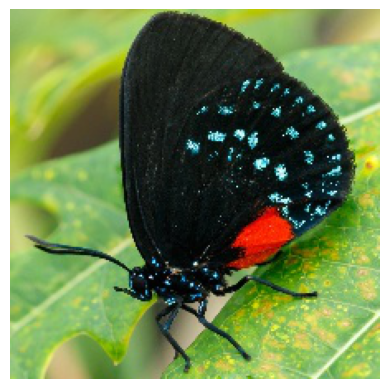

In [31]:
image_np2 = initial_img.squeeze().cpu().detach().numpy()

# If the image has more than one channel, transpose the dimensions from [C, H, W] to [H, W, C]
if image_np2.ndim == 3:
    # Transpose the image for plotting
    image_np2 = image_np2.transpose(1, 2, 0)

# If the image is in the range [0, 1], ensure it's scaled to [0, 255] if needed
if image_np2.max() <= 1.0:
    image_np2 = (image_np2 * 255).astype(np.uint8)

# Plot the image
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(image_np1)
plt.title('Adversarial Image_processing')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(image_np2)
plt.title('Original Image')
plt.axis('off')
